In [1]:
import os

import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img

import random
import numpy as np
from matplotlib import pyplot as plt

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo'
  # augmented: data_path = '/content/gdrive/My Drive/Colab Notebooks/martin/fluo/aug'
except:
  import os
  from pathlib import Path
  here = os.getcwd()  # os.path.abspath(os.path.dirname(__file__))
  data_path = str(Path(here).joinpath('../data/toy/fluo'))

print('getting data from {}, folders there are: {}'.format(data_path, list(os.walk(data_path))[0][1]))

image_size = (128, 128)  # original is 1100 x 700
input_shape = (*image_size, 1)
best_model_weights = 'model.h5'

Mounted at /content/gdrive


In [2]:
def get_data(imgs_path, masks_path, im_size):
    """ Get and resize train images and masks """

    im_width, im_height = im_size
    list_imgs = next(os.walk(imgs_path))[2]
    X = np.zeros((len(list_imgs), im_width, im_height, 1), dtype=np.float32)
    y = np.zeros((len(list_imgs), im_width, im_height, 1), dtype=np.float32)
    
    for i, img_name in enumerate(list_imgs):
        mask_name = img_name.replace('img_', 'mask_')
        
        # load images
        img = img_to_array(load_img(imgs_path + '/' + img_name, color_mode = 'grayscale'))
        img = resize(img, (im_width, im_height, 1), preserve_range=True)

        # load masks
        mask = img_to_array(load_img(masks_path + '/' + mask_name, color_mode = 'grayscale'))
        mask = resize(mask, (im_width, im_height, 1), preserve_range=True)

        # save images
        X[i, ..., 0] = img.squeeze() / 255
        y[i] = mask / 255

    return X, y

# get data
X, y = get_data(data_path + '/images', data_path + '/masks', image_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15)  # split train and test

print('found {} samples: {} training, {} validation'.format(len(X), len(X_train), len(X_valid)))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


found 92 samples: 78 training, 14 validation


In [3]:
def plot_train_sample(X, y, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('image (input)')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('mask (output)')

    return ix

def plot_pred_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X) - 1)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[0].set_title('image + mask')

    ax[1].imshow(preds[ix].squeeze(), cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='yellow', levels=[0.5])
    ax[1].set_title('predicted + original mask')

    return ix

def plot_results(results):
    plt.figure(figsize=(24, 8))

    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_acc")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

    plt.xlabel("epochs")
    plt.ylabel("log loss")
    plt.legend()

plot_train_sample(X_train, y_train)  # check if training data looks all right

46

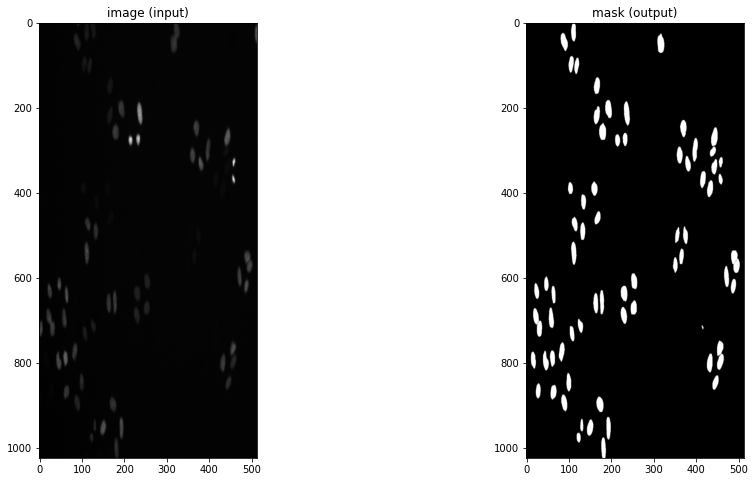

In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_unet(input_img, n_filters, dropout=0.5, batchnorm=True):
    pooling = MaxPooling2D

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = pooling((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = pooling((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = pooling((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = pooling((2, 2)) (c4)
    p4 = Dropout(dropout)(p4)

    # u path
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)

    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

input_img = Input(input_shape, name='img')
model = get_unet(input_img, 64, dropout=0.5, batchnorm=False)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])
# model.summary()

from tensorflow.keras import backend as K
K.clear_session()

In [6]:
verbose = 1
batch_size = 4
epochs = 20

callbacks = [
    EarlyStopping(patience=10, verbose=verbose),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=verbose),
    ModelCheckpoint(best_model_weights, monitor='loss', verbose=verbose, save_best_only=True, save_weights_only=True)
]
results = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_valid, y_valid))

plot_results(results)

model.load_weights(best_model_weights)  # load best model
model.evaluate(X_valid, y_valid, verbose=verbose)  # evaluate on validation set

preds_train = model.predict(X_train, verbose=verbose)  # predict
preds_val = model.predict(X_valid, verbose=verbose)

Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
# plot_pred_sample(X_train, y_train, preds_train)  # predictions on training data
plot_pred_sample(X_valid, y_valid, preds_val)  # predictions on test data